# Automatic segmentation for Pointrobotics Data

# Load DICOM data

In [1]:
import pydicom
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from os import walk
PathDicom = './data/Pointrobotics/ImageDB/Image_20180509/Case2/CT/S6220/S2020_TH1_Gap0.8/'
lstFilesDCM = []
# get all file name in a directory
for (dirpath, dirnames, filenames) in walk(PathDicom):
    #print(filenames)
    lstFilesDCM.extend(filenames)
    break

lstFilesDCM = sorted(lstFilesDCM, key=lambda path: int(path[1:]))
#print(lstFilesDCM)

for i in range(len(lstFilesDCM)):
    lstFilesDCM[i] = PathDicom + lstFilesDCM[i]
    
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0], force=True)
print(RefDs)

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print ('ConstPixelDims', ConstPixelDims)
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print ('ConstPixelSpacing', ConstPixelSpacing)

size = ConstPixelDims[0]
data_shape = (len(lstFilesDCM), size, size)
x = np.zeros(data_shape)

i = 0
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # file name
    filename = filenameDCM.split('/')[-1]
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    img = ds.pixel_array

    x[i,:,:] = img
    i += 1
    
print(x.shape)
plt.imshow(x[:,:,int(x.shape[2]/2)], cmap='gray')

# resize the 3d image
from scipy.ndimage import zoom
# from sklearn.preprocessing import normalize

# norm1 = x / np.linalg.norm(x)

scale = 1

x = zoom(x, (
    ConstPixelSpacing[2] * scale,
    ConstPixelSpacing[1] * scale,
    ConstPixelSpacing[0] * scale))

print('shape', x.shape)

data_shape = x.shape

x_original = x

x_original = (x_original - x_original.min())/(x_original.max() - x_original.min())

# def windowing(img):
#     window_width, window_level = 1800, 400
#     upper, lower = window_level + window_width / 2, window_level - window_width / 2
#     img = np.clip(img,lower,upper)
#     img = (img - lower) / window_width
#     return img

def windowing(img, lower, upper):
    
    slope = 1
    intercept = -1024
    img = img * slope + intercept

    img = np.clip(img,lower,upper)
    img = (img - lower) / (upper - lower)
    
    return img

x = windowing(x, 100, 1000)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20171205'
(0008, 0013) Instance Creation Time              TM: '154005.660'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.46.670589.33.1.63648085205654655100001.4702291070137030256
(0008, 0020) Study Date                          DA: '20171205'
(0008, 0021) Series Date                         DA: '20171205'
(0008, 0022) Acquisition Date                    DA: '20171205'
(0008, 0023) Content Date                        DA: '20171205'
(0008, 002a) Acquisition DateTime                DT: '20171205023925.050'
(0008, 0030) Study Time                          TM: '153723.961'
(0008, 0031) Series Time                         TM: '153940.221'
(0008, 0032) Acquisition Time                    TM: '153925'
(0008, 0

# Detect vertebrae coordinates

./darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < data/ian/test/script_point.txt > data/ian/test/script_point_result.txt -i 0
b''
== YOLO pedicted ==
z_center:  121


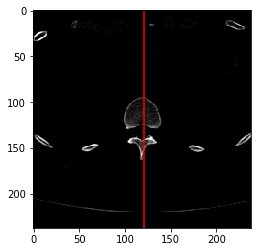

In [2]:
for i in range(x_original.shape[2]):
    cv2.imwrite('./darknet/data/ian/test/script_point{}.png'.format(i), x_original[:,:,i] * 255)
    
script_name_lst = []

for i in range(x_original.shape[2]):
    script_name_lst.append('data/ian/test/script_point{}.png'.format(i))

with open('./darknet/data/ian/test/script_point.txt', 'w') as f:
    for item in script_name_lst:
        f.write("%s\n" % item)

# YOLO predict

import subprocess
import os

origin_dir = os.getcwd()
os.chdir('./darknet')

#cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_50000.weights data/ian/test/case1_97.jpg'
cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < {} > {} -i {}'.format(
    'data/ian/test/script_point.txt',
    'data/ian/test/script_point_result.txt',
    '0')# GPU
print(cmdstr)

detect_result = subprocess.check_output(cmdstr, shell = True)

os.chdir(origin_dir)

print(detect_result)
print('== YOLO pedicted ==')

# Load YOLO predict result

import re

with open('./darknet/data/ian/test/script_point_result.txt', 'r') as f:
    content = f.read().split('Enter Image Path:')

    slice_results = []
    detected_num_lst = []
    
    for i in range(1, x_original.shape[2]):
        
        yolo_results = []
        
        result = content[i].split('\n')
        del result[0], result[-1]

        for line in result:
            yolo_results.append({
                'label': line.split(':')[0],
                #'confidence': int(re.sub("\D", "", line.split('%')[0].split(':')[1])),
                'left_x': int(re.sub("\D", "", line.split(':')[2])),
                'top_y': int(re.sub("\D", "", line.split(':')[3])),
                'center_x': int(int(re.sub("\D", "", line.split(':')[2])) + int(re.sub("\D", "", line.split(':')[4]))/2),
                'center_y': int(int(re.sub("\D", "", line.split(':')[3])) + int(re.sub("\D", "", line.split(':')[5]))/2),
                'w': int(re.sub("\D", "", line.split(':')[4])),
                'h': int(re.sub("\D", "", line.split(':')[5])),
            })

        yolo_results = sorted(yolo_results, key=lambda r: r['center_y'])
        slice_results.append(yolo_results)
        detected_num_lst.append(len(yolo_results))

z_lst = []

for z, n in enumerate(detected_num_lst):
    if n > max(detected_num_lst)/2:
        z_lst.append(z)
        
z = z_lst[int(len(z_lst)/2)]
print('z_center: ', z)

yolo_results = slice_results[z]


plt.plot((z, z), (0, data_shape[1]), '-', color='red')
plt.imshow(x[50,:,:], cmap='gray')

# Show vertebrae centers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

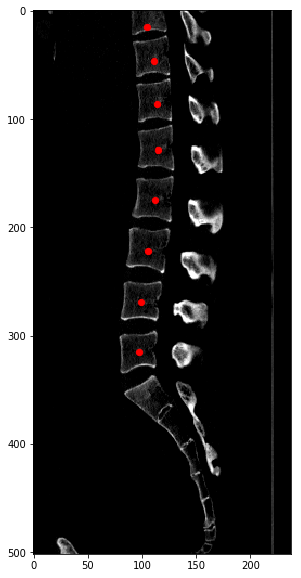

In [3]:
# Draw point
import numpy as np
import random

x_coords = []
y_coords = []
labels = []
for result in yolo_results:
    #print(result)
    x_coords.append(result['center_x'])
    y_coords.append(result['center_y'])
    labels.append(result['label'])
    

plt.figure(figsize=(10, 10))
plt.imshow(x[:,:,z], cmap='gray')

for i in range(len(x_coords)):
    #color = [1, 0 + random.random()/2, 0.5 + random.random()/2]
    x_coord, y_coord, label = x_coords[i], y_coords[i], labels[i]
    plt.scatter(x = x_coord, y = y_coord, c = [1,0,0], s = 40)
    #plt.text(x_coord + 15, y_coord, label, fontsize=16, color = color)

plt.show()

# Segmentation and Classification

Using TensorFlow backend.
/home/ian/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


libs loaded
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
label 10 	 confidence 0.9994646906852722
label 13 	 confidence 0.7670339941978455
label 14 	 confidence 0.9622455835342407
label 15 	 confidence 0.9486053586006165
label 15 	 confidence 0.796661913394928
label 16 	 confidence 0.9254626035690308
label 17 	 confidence 0.9310411214828491
label 19 	 confidence 0.5238096714019775
0 	 as head, average confidence 5.554667705091134e-06
1 	 as head, average confidence 1.551918370435156e-06
2 	 as head, average confidence 1.2617342909590626e-06
3 	 as head, average confidence 3.607170488252833e-06
4 	 as head, average confidence 2.4495510197979954e-06
5 	 as head, average confidence 1.560907127604377e-05
6 	 as head, average confidence 8.909590715646518e-05
7 	 as head, average confidence 0.00020414401765678935
8 	 as head, average confidence 4.630227673127143e-06
9 	 as head, average confidence 2.609355890201652e-05
10 	 as head, average confidence 0.05675412111101556
11 	 as head, average confidence 

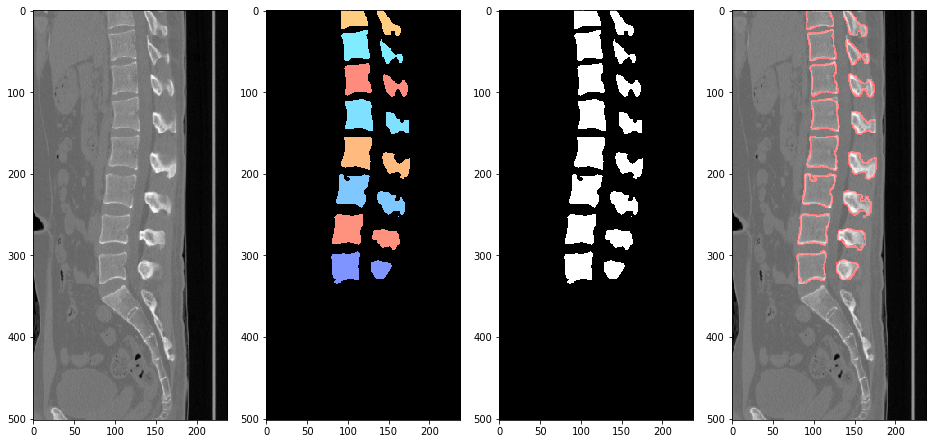

In [4]:
import keras
from keras import backend as K
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random
import re

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def setGPU():
    import tensorflow as tf
    tf.config.gpu.set_per_process_memory_growth(enabled=True)

setGPU()

print('libs loaded')

size = 128

# Load Deeplab 3D

from model3d import Deeplabv3

deeplab_model = Deeplabv3(
    input_shape=(128, 128, 128, 1),
    classes=1,
    weights=None,
    backbone = 'xception',
    activation='sigmoid')

def load_weights():
#     weight_path = '../keras-deeplab-v3-plus/save/model.3dxceptionwindow0416.weights.last.h5'
    weight_path = './weights/model.3dxceptionHU0416.weights.last.h5'
    file=h5py.File(weight_path,'r')
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
    deeplab_model.set_weights(weight)

load_weights()

# Load Xception

from xception3d import Xception

size = 128

model2 = Xception(
    input_shape = (size, size, size, 1),
    classes = 20
)

model2.load_weights('./weights/model.xception0419.weights.last.h5')

def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def generate_seg_result(vertebrae):
    # generate segmentation test data .npy
    shape = x.shape

    #vertebrae = {'label': 'T8', 'left_x': 65, 'top_y': 154, 'center_x': 98, 'center_y': 187, 'w': 67, 'h': 67}

    center_x, center_y = vertebrae['center_x'], vertebrae['center_y']

    size = 128 # patch size = size*size*size
    min_x, max_x, min_y, max_y = center_x - size/2, center_x + size/2, center_y - size/2, center_y + size/2

    range_x = [
        int(min_x if min_x > 0 else 0),
        int(max_x if max_x < (shape[1] - 1) else (shape[1] - 1))
    ]
    range_y = [
        int(min_y if min_y > 0 else 0),
        int(max_y if max_y < (shape[0] - 1) else (shape[0] - 1))
    ]
    range_z = [
        int(z - size/2),
        int(z + size/2)
    ]
    #print(range_x)
    #print(range_y)
    #print(center_x)

    padding_y = (
    int(size/2) - center_y + range_y[0],
    int(size/2) - range_y[1] + center_y
    )
    padding_x = (
        int(size/2) - center_x + range_x[0],
        int(size/2) - range_x[1] + center_x
    )

    out_x = np.pad(
        x[
            range_y[0]: range_y[1]
            , range_x[0]: range_x[1]
            , range_z[0]: range_z[1]],
        (padding_y, padding_x, (0, 0)),
        'constant') #/ 255
    
    #out_x = (out_x - out_x.min()) / (out_x.max() - out_x.min())
    
    #out_x = out_x * 255
    
    #out_x = image_histogram_equalization(out_x.astype(int))[0] / 255

    #plt.imshow(out_x[:,:,64], cmap='gray')
    #np.save('./tmp/seg_test_data/{}.npy'.format(vertebrae['label']), out_x)
    
    out_x = np.reshape(out_x, (1, 128, 128, 128, -1))
    
    print(out_x.max())
    
    out_y = deeplab_model.predict(out_x)
    
    out_y = np.reshape(out_y, (128, 128, 128))
    
    #plt.imshow(out_y[:,:,z], cmap='gray')
    
    return out_y

# combine seg result

combine_result = np.zeros(x.shape)

# combine
size = 128
seg_results = np.zeros((len(yolo_results) ,size, size, size))
label_results = []

for i in range(len(yolo_results)):
    seg_result = generate_seg_result(yolo_results[i])
    #plt.imshow(seg_result[:,:,60] > 0.5, cmap='gray')
    seg_results[i] = seg_result
    
    label_result = model2.predict(np.reshape(seg_result, (1, 128, 128, 128, -1)))[0]
    label_results.append(label_result)

#print(label_results)
for label_result in label_results:
    print('label {} \t confidence {}'.format(np.argmax(label_result), max(label_result)))

n_of_vertebrae = len(yolo_results)
confidences = [] # conf of labels start from


for i in range(20): # label start from
    sum_of_confidences = 0
    for n in range(n_of_vertebrae):
        #print(label_results[n][(i + n) % 20])
        sum_of_confidences += label_results[n][(i + n) % 20]
    #print(sum_of_confidences / 20)
    confidences.append(sum_of_confidences / 20)
    print('{} \t as head, average confidence {}'.format(i, sum_of_confidences / 20))

head = np.argmax(confidences)
print()
print('Result: choose {} as head'.format(head))
print('From {} to {}'.format(head, head + n_of_vertebrae -1))

# generate final result
# (559, 160, 160)
import random

final_result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size)) # 64 padding
final_result_colored = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size, 3)) # colored

for i in range(len(yolo_results)):
    
    x_start = yolo_results[i]['center_x'] - 64 + 64
    x_end = yolo_results[i]['center_x'] + 64 + 64
    
    y_start = yolo_results[i]['center_y'] - 64 + 64
    y_end = yolo_results[i]['center_y'] + 64 + 64
    
    result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size))
    result[y_start:y_end, x_start:x_end, (z - 64 + 64):(z + 64 + 64)] = seg_results[i][:, :, :] > 0.5 # (y, x, z)
    
    final_result[np.where(result > 0.5)] = 1
    final_result_colored[np.where(result > 0.5)] = [
        (1 if i%2 == 0 else 0.5),
        random.random()/2 + 0.5,
        (0.5 if i%2 == 0 else 1)]
    
#     for p in range(0, size):
#         for q in range(0, size):
#             for r in range(0, size):
#                 if seg_results[i][p, q, r] > 0.5:
#                     final_result[p + 64, q + 64, r + 64] = 1
    
final_result = final_result[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]
final_result_colored = final_result_colored[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]

def contour_result(x, mask):    
    def sobel(img):
        x = cv2.Sobel(img,cv2.CV_16S,1,0)
        y = cv2.Sobel(img,cv2.CV_16S,0,1)
        absX = cv2.convertScaleAbs(x)
        absY = cv2.convertScaleAbs(y)
        dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
        dst = np.where(dst > 0, 1.0, 0)
        return dst
    contour = sobel(mask)
    original = np.stack((x/255,)*3, axis=-1)
    original = (original - original.min())/(original.max() - original.min())
    red_contour = np.stack((contour, np.zeros(contour.shape), np.zeros(contour.shape)), axis=-1)
    contour_conbine = np.where(red_contour > 0, red_contour, original)
    return contour_conbine

plt.figure(figsize=(16, 12))
plt.subplot(141)
plt.imshow(x_original[:,:,z], cmap='gray')
plt.subplot(142)
plt.imshow(final_result_colored[:,:,z,:])
plt.subplot(143)
plt.imshow(final_result[:,:,z], cmap='gray')
plt.subplot(144)
plt.imshow(contour_result(x_original[:,:,z], final_result[:,:,z]))

# Output result to png slices

In [5]:
path = './result/result_point'

os.makedirs(path)

for i in range(x.shape[2]):
    cv2.imwrite(path + '/{}.png'.format(i), final_result_colored[:,:,i] * 255)
    